# **Comparison of all the approaches (considering makespan and regularity)**


In this file, we compare all the approaches (clustering, binary decision tree and neural network) for the scheduling problem of **jobshop**.

---

## DOcplex Python API installation

First, we install the docplex python API which we will use for modelling our problem and solving it. (Then, we will not have problem size error)

In [1]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex -q
        print("!pip install docplex -q...")
    else:
        !pip install --user docplex -q
        print("!pip install --user docplex -q...")
        
print("End of the intallation of python API...")

End of the intallation of python API...



---

## Main code

In [2]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default

from sklearn import tree
from matplotlib import pyplot as plt
from Solver import *
from User import *
import time

In [3]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm
sys.path.append('./bdt/')
import decision_tree as dt

In [4]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 20

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20




# The number of solutions that we will have in the solver after the first iteration
k_k = 15
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)


--------Main program is loading...---------


----

### Approach with clustering

In [5]:

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, starts = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)


# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 3880
Le max de list_obj est 5312
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x00000209F1677340>, <docplex.cp.solution.CpoSolveResult object at 0x00000209EAF0B840>, <docplex.cp.solution.CpoSolveResult object at 0x00000209E80FFA40>, <docplex.cp.solution.CpoSolveResult object at 0x00000209E64E7E40>], [<docplex.cp.solution.CpoSolveResult object

In [6]:
####################################################################
#### Arbre de décision : RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################


###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj_BDT2 = [min(list_obj)]
list_min_obj_global_BDT2 = [min(list_obj)] 
criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    
    print("\n--------Iteration {}---------".format(it))
    it += 1

     # --------- Compute two decision trees---------------
    clf1, feuilles_conditions1 = dt.my_decision_tree(n, m, list_layers)
    clf2, feuilles_conditions2 = dt.my_decision_tree(n, m, list_layers)
    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    
      
    #----------Add news variables "order1" and "order2" to the model---------------
    order1 = model.binary_var(name="order1")
    order2 = model.binary_var(name="order2")
    solver.add_variable(order1)
    solver.add_variable(order2)
    
   
    # --------- Add the new constraints to the model (concerning the order)
    list_variables = [model.start_of(variables[i//m][i%m]) for i in range(n*m)]
    constraint_list_of_tree1 = dt.constraint_tree(order1,list_variables, feuilles_conditions1)
    constraint_list_of_tree2 = dt.constraint_tree(order2,list_variables, feuilles_conditions2)



    for constraint in constraint_list_of_tree1:
        solver.add_constraint(model, constraint)
    for constraint in constraint_list_of_tree2:
        solver.add_constraint(model, constraint)
    solver.add_constraint(model, equal(order1, 1))
    solver.add_constraint(model, equal(order1, order2))


    # ------------ Solve the model
    print("\nSolving the model...")
    model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol) + user.objectiveFunctionRegularity(sol, n, m))
        # list.append(user.objectiveFunction(sol) * user.objectiveFunctionRegularity(sol, n, m))
    
    if len(list) == 0:
        print("No solution at iteration", it)
        continue

    list_min_obj_BDT2.append(min(list))
    print("Objective function :", list_min_obj_BDT2)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global_BDT2.append(min(list_obj))
    print("Objective function global :", list_min_obj_global_BDT2)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max) 
    

    fm.stopCondition(it, it_max, tps, tps_max)
it_final_BDT2 = it


--------Iteration 1---------
best score:  1.0
best score:  1.0

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 7379
Objective function : [3880, 3249]
Model solved !

Classing solutions...
Le min de list_obj est 3249
Le max de list_obj est 5312
Solutions classed !

Creating preferences...
Preferences created !
Il y a 30 solution(s)
Objective function global : [3880, 3249]

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

--------Iteration 2---------
best score:  1.0
best score:  1.0

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the

[3880, 3249, 3912, 4096, 3978, 3602, 3879, 3129, 3494, 3398, 3442, 3573, 3423, 3580, 3226]


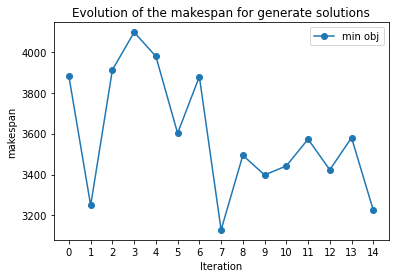

In [7]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

print(list_min_obj_BDT2)
plt.plot([i for i in range(it)], list_min_obj_BDT2, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[3880, 3249, 3249, 3249, 3249, 3249, 3249, 3129, 3129, 3129, 3129, 3129, 3129, 3129, 3129]


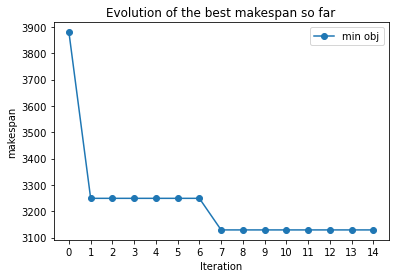

In [8]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global_BDT2)
plt.plot([i for i in range(it)], list_min_obj_global_BDT2, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

-----

### Approach with binary decision tree

In [9]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 20

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300
tps = 0

# Number of iteration stop criterion
it_max = 20
it = 0




# The number of solutions that we will have in the solver after the first iteration
k_k = 15

#############################
### Main program ###
#############################

#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, starts = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 3895
Le max de list_obj est 5357
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x00000209F2E93140>, <docplex.cp.solution.CpoSolveResult object at 0x00000209E1E790C0>, <docplex.cp.solution.CpoSolveResult object at 0x00000209EAE21F40>], [<docplex.cp.solution.CpoSolveResult object at 0x00000209EFB49D40

In [10]:
####################################################################
#### Arbre de décision : RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################


###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj_BDT = [min(list_obj)]
list_min_obj_global_BDT = [min(list_obj)] 
criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    
    print("\n--------Iteration {}---------".format(it))
    it += 1

     # --------- Compute decision trees---------------
    clf, feuilles_conditions = dt.my_decision_tree(n, m, list_layers)
    
    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    
      
    #----------Add new variable "order" to the model---------------
    order = model.binary_var(name="order")
    solver.add_variable(order)
    
   
    # --------- Add the new constraints to the model (concerning the order)
    list_variables = [model.start_of(variables[i//m][i%m]) for i in range(n*m)]
    constraint_list_of_tree = dt.constraint_tree(order,list_variables, feuilles_conditions)

    for constraint in constraint_list_of_tree:
        solver.add_constraint(model, constraint)
    solver.add_constraint(model, equal(order, 1))


    # ------------ Solve the model
    print("\nSolving the model...")
    model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol) + user.objectiveFunctionRegularity(sol, n, m))
        # list.append(user.objectiveFunction(sol) * user.objectiveFunctionRegularity(sol, n, m))
        
    list_min_obj_BDT.append(min(list))
    print("Objective function :", list_min_obj_BDT)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global_BDT.append(min(list_obj))
    print("Objective function global :", list_min_obj_global_BDT)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max) 

    fm.stopCondition(it, it_max, tps, tps_max)
it_final_BDT = it


--------Iteration 1---------
best score:  1.0

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 7219
Objective function : [3895, 3259]
Model solved !

Classing solutions...
Le min de list_obj est 3259
Le max de list_obj est 5357
Solutions classed !

Creating preferences...
Preferences created !
Il y a 30 solution(s)
Objective function global : [3895, 3259]

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

--------Iteration 2---------
best score:  1.0

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints 


--------Implementation of the decision tree...---------
14


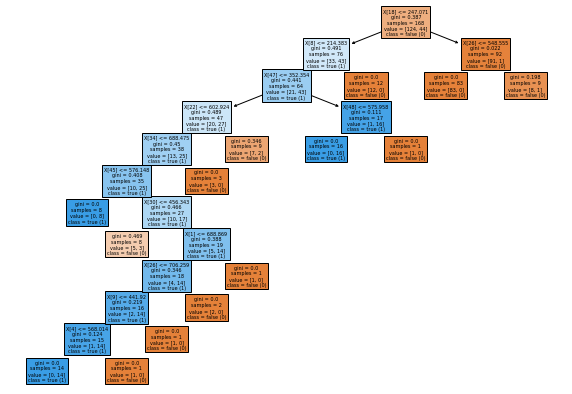

In [11]:
# Implementation of the decision tree

print("\n--------Implementation of the decision tree...---------")
print(len(feuilles_conditions)) 
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf, 
                    class_names= ("false (0)", "true (1)" ), 
                    filled=True)

[3895, 3259, 4247, 3000, 4157, 4570, 4141, 4184, 3176, 4972, 3207, 4274, 3275, 3761, 4081]


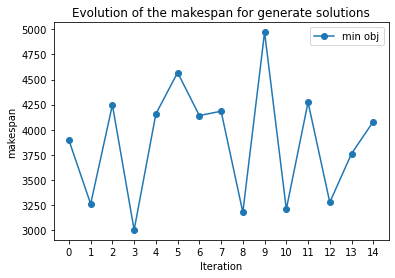

In [12]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

print(list_min_obj_BDT)
plt.plot([i for i in range(it)], list_min_obj_BDT, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[3895, 3259, 3259, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]


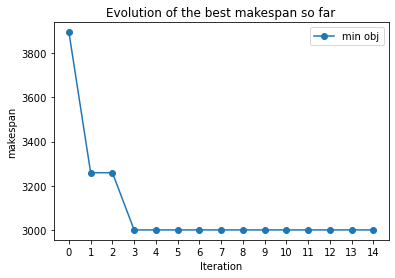

In [13]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global_BDT)
plt.plot([i for i in range(it)], list_min_obj_global_BDT, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

----

## Plots in the same frame

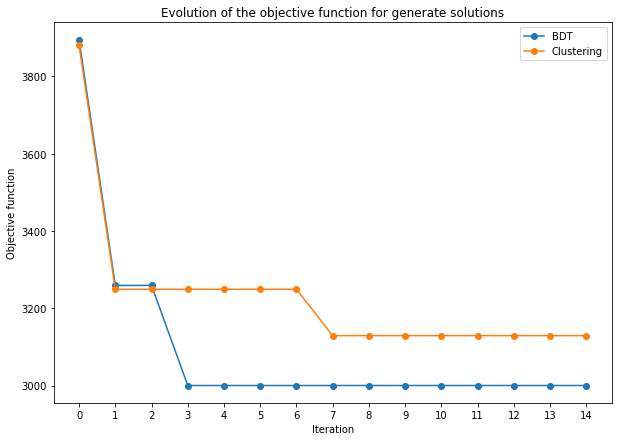

In [14]:
plt.figure(figsize=(10,7))
plt.plot([i for i in range(it_final_BDT)], list_min_obj_global_BDT, label='BDT', marker='o')
plt.plot([i for i in range(it_final_BDT2)], list_min_obj_global_BDT2, label='Clustering', marker='o')

plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.title("Evolution of the objective function for generate solutions")
plt.xticks(range(max(it_final_BDT, it_final_BDT2)))
plt.legend()
plt.show()

